In [1]:
import json
from glob import glob
import os
import multiprocessing as mp
from time import time

In [2]:
import pandas as pd
import numpy as np
import dask.dataframe as dd
from dask.diagnostics import ProgressBar

from rdkit.Chem.AllChem import ReactionFromSmarts

from rdkit.Chem import CanonSmiles

In [3]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [4]:
#to disable warnings
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

In [5]:
from matplotlib import pyplot as plt

In [7]:
from ord_data_load import df_na_vals, parse_pb_file

%load_ext autoreload
%autoreload 2

ORD_REPO_PATH = './ord-data'
ORD_PATH = './ORD'

## Load and clean data

In [8]:
""" Multiprocessing """
start = time()

n_cores = 24
args = [(pb, ORD_PATH) for pb in glob(f'{ORD_REPO_PATH}/data/*/*.pb.gz')]
N = len(args)

with mp.Pool(n_cores) as p:
    p.starmap(parse_pb_file, args)

t = time() - start
s = int(t % 60)
m = int((t // 60) % 60)
h = int((t // 60) / 60)
print(f'{N} datasets parsed in {h:02d}h:{m:02d}m:{s:02d}s')

515 datasets parsed in 00h:09m:39s


In [9]:
dataset_paths = sorted(glob(f'{ORD_PATH}/parsed/*.json'))
N = len(dataset_paths)
print(N)

506


In [10]:
start = time()
all_reactions = dd.read_json(
    dataset_paths,
    orient='columns',
    dtype='object',
    include_path_column=True,
    path_converter=lambda x: os.path.split(x)[1].split('.')[0]
).rename(columns={'path': 'original_dataset'}).compute(scheduler='threads')

all_reactions.reset_index(drop=True, inplace=True)

t = time() - start
s = int(t % 60)
m = int((t // 60) % 60)
h = int((t // 60) / 60)
print(f'{N} datasets parsed in {h:02d}h:{m:02d}m:{s:02d}s')

506 datasets parsed in 00h:00m:58s


In [11]:
print(all_reactions.shape)
df_na_vals(all_reactions, False)

(1790148, 13)
id                    ->         Missing values: 0 (0.00%)
reaction_smile        ->         Missing values: 19116 (1.07%)
solvents              ->         Missing values: 404697 (22.61%)
reactants             ->         Missing values: 0 (0.00%)
catalysts             ->         Missing values: 1523003 (85.08%)
reagents              ->         Missing values: 1773144 (99.05%)
temperature           ->         Missing values: 687161 (38.39%)
time                  ->         Missing values: 897258 (50.12%)
product               ->         Missing values: 40191 (2.25%)
yield                 ->         Missing values: 816308 (45.60%)
notes                 ->         Missing values: 12044 (0.67%)
patent                ->         Missing values: 19116 (1.07%)
original_dataset      ->         Missing values: 1790148 (100.00%)


In [12]:
# all_reactions.to_csv(f'{ORD_PATH}/all_reactions.csv', index=False)
# all_reactions['reactions'].apply(eval)
%time all_reactions.to_pickle(f'{ORD_PATH}/all_reactions.pkl')

CPU times: total: 19.3 s
Wall time: 19.4 s


## Separate the reaction of specific types into dataframes

In [13]:
%time
all_reactions = pd.read_pickle(f'{ORD_PATH}/all_reactions.pkl')

CPU times: total: 39.4 s
Wall time: 39.4 s


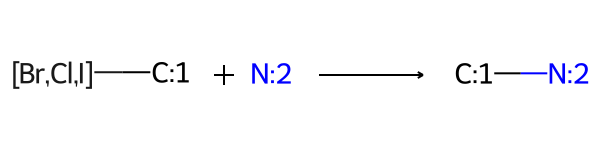

In [15]:
from ord_data_load import is_reaction_of_type
from ord_data_load import draw_reaction_rand

SUZUKI_RXN_SMARTS = "[B;X3,4]-[C,c:1].[C,c:2]-[Cl,Br,I,O]>>[C,c:1]-[C,c:2]"
BUCHWALD_RXN_SMARTS = "[c:1]-[Br,Cl,I].[NX3:2]>>[c:1]-[NX3:2]"
ReactionFromSmarts(BUCHWALD_RXN_SMARTS)

In [16]:
%%time
rxn_pattern = ReactionFromSmarts("[B;X3,4]-[C,c:1].[C,c:2]-[Cl,Br,I,O]>>[C,c:1]-[C,c:2]")

mask = all_reactions['reaction_smile'].apply(is_reaction_of_type, reaction_type_pattern=rxn_pattern)
df_reactions = all_reactions[mask].copy()

KeyboardInterrupt: 

In [10]:
%%time
mask = all_reactions['reaction_smile'][:24000].apply(is_reaction_of_type, reaction_type_pattern=rxn_pattern)
df_reactions_1 = all_reactions[:24000][mask].copy()

CPU times: total: 12.7 s
Wall time: 12.7 s


In [11]:
from dask.diagnostics import ProgressBar
ProgressBar().register()

dds = dd.from_pandas(all_reactions['reaction_smile'], npartitions=240)
mask = dds.apply(is_reaction_of_type,
                 reaction_type_pattern=rxn_pattern,
                 meta=pd.Series(dtype=bool)).compute(scheduler='processes')

[########################################] | 100% Completed | 15.8s


In [184]:
df_reactions.reset_index(drop=True, inplace=True)
df_reactions.to_pickle(f'{ORD_PATH}/suzuki_reactions.pkl')

In [12]:
df_suzuki = pd.read_pickle(f'{ORD_PATH}/suzuki_reactions.pkl')

In [18]:
rxn_pattern = ReactionFromSmarts("[B;X3,4]-[C,c:1].[C,c:2]-[Cl,Br,I,O]>>[C,c:1]-[C,c:2]")

%time mask = all_reactions['reaction_smile'][:2000].apply(is_reaction_of_type, reaction_type_pattern=rxn_pattern)

CPU times: total: 688 ms
Wall time: 698 ms


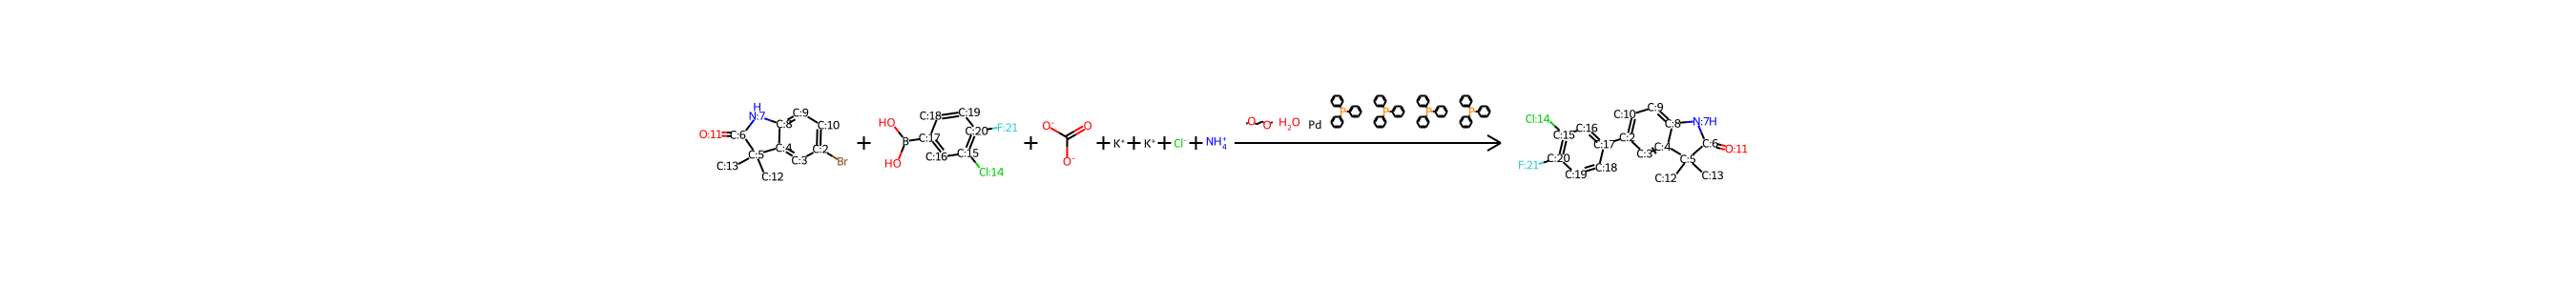

In [60]:
suzuki_pattern = ReactionFromSmarts(SUZUKI_RXN_SMARTS)
buchwald_patter = ReactionFromSmarts()

In [62]:
df_suzuki = pd.DataFrame()
# df_amide = pd.DataFrame()

for i, dataset_path in enumerate(dataset_paths, 1):
    print(f'Analyzing dataset {i: 3d}/{N}', end='\r')
    with open(dataset_path, 'r') as file:
        dataset = json.load(file)

    suzuki_additions = []
    amide_additions = []

    for reaction in dataset:
        if reaction.get('reaction_smile') is None:
            continue

        reaction_smiles = reaction['reaction_smile']
        if is_reaction_of_type(reaction_smiles, suzuki_pattern):
            suzuki_additions.append(reaction)
        # elif is_reaction_of_type(reaction_smiles, amide_pattern):
        #     amide_additions.append(reaction)

    df_suzuki = pd.concat([df_suzuki, pd.DataFrame(suzuki_additions)], axis=0, join='outer')
    # df_amide = df_amide.append(pd.DataFrame(amide_additions))
df_suzuki.reset_index(drop=True, inplace=True)

In [63]:
df_suzuki.shape

(50347, 11)

In [ ]:
# df_amide.shape

In [65]:
df_suzuki.to_csv(f'{ORD_PATH}/suzuki_reactions.csv', index=False)

# df_amide.to_csv(f'{ORD_PROCESSED_PATH}/ORD/amide_couplings.csv', index=False)

## Inspect the contents

In [66]:
all_reactions.loc[all_reactions['temperature'].apply(lambda x: isinstance(x, str)), 'temperature'].value_counts()

AMBIENT               562148
CUSTOM                  1729
DRY_ALUMINUM_PLATE       450
AIR_FAN                    9
Name: temperature, dtype: int64

In [67]:
(all_reactions['temperature_adjusted'].isna()).mean()

KeyError: 'temperature_adjusted'

In [ ]:
all_reactions['temperature_adjusted'] = all_reactions['temperature'].apply(lambda x: 25 if x=='AMBIENT' else
                                                                                     None if isinstance(x, str) else
                                                                                     None if x is None else
                                                                                     x if (-120 < x < 250) else
                                                                                     None)

In [ ]:
all_reactions['time_adjusted'] = all_reactions['time'].apply(lambda t: None if t <= 0 or t > 100 else t)

In [ ]:
plt.figure(figsize=[20,10])
# plt.xlim([-120, 250])
all_reactions['time'].hist(bins=100)
plt.show()

In [ ]:
df_suzuki = pd.read_csv(f'{ORD_PATH}/ORD/suzuki_reactions.csv')
# df_amide = pd.read_csv('/homes/fabrizio.ambrogi/Data/Grant_project2/ORD/amide_couplings.csv')

In [ ]:
for key in ('solvents', 'reactants', 'catalysts', 'solvents_names', 'catalysts_names', 'reagents',):
    df_suzuki[key] = df_suzuki[key].apply(eval)
    df_amide[key] = df_amide[key].apply(eval)

In [ ]:
df_na_vals(df_suzuki, False)

In [ ]:
df_na_vals(df_amide, False)

### Solvents

In [ ]:
solvent_names = []
solvent_smiles = []
for solvents in df_suzuki['solvents']:
    for (name, smiles) in solvents:
        solvent_names.append(name)
        solvent_smiles.append(CanonSmiles(smiles) if smiles else None)
        
for solvents in df_amide['solvents']:
    for (name, smiles) in solvents:
        solvent_names.append(name)
        solvent_smiles.append(CanonSmiles(smiles) if smiles else None)
        
df_solvents = pd.DataFrame({'names': solvent_names, 'smiles': solvent_smiles})
name_counts = dict(df_solvents.groupby('names')['smiles'].apply(len))

df_solvents = df_solvents.groupby('smiles').apply(lambda db: pd.Series({'names': tuple(sorted(set(db['names']))), 'count': len(db)})).sort_values('count', ascending=False)
df_solvents['count'] /= len(df_suzuki)

df_solvents.reset_index(inplace=True)

In [ ]:
solvent_names_map = {}
solvent_name2smiles = {}
for i, row in df_solvents.iterrows():
    solvent_group = row['names']
    solvent_smiles = row['smiles']
    names = sorted(solvent_group, key=lambda x: -name_counts.get(x, 0))
    for name in names:
        solvent_names_map[name] = names[0]
        solvent_name2smiles[name] = solvent_smiles 

In [ ]:
solvent_names_map['ethylene glycol dimethyl ether'] = 'DME'

In [ ]:
df_suzuki['solvents_names'] = df_suzuki['solvents'].apply(lambda x: tuple(sorted(set(solvent_names_map.get(name, name) for name, smiles in x))))

In [ ]:
df_suzuki['solvents_names'].value_counts().head(25)

In [ ]:
all_solvents = set()
df_suzuki['solvents_names'].apply(lambda names: all_solvents.update(set(names)))

len(all_solvents)

In [ ]:
df_amide['solvents_names'] = df_amide['solvents'].apply(lambda x: tuple(sorted(set(solvent_names_map.get(name, name) for name, smiles in x))))

In [ ]:
df_amide['solvents_names'].value_counts().head(25)

In [ ]:
all_solvents = set()
df_amide['solvents_names'].apply(lambda names: all_solvents.update(set(names)))

len(all_solvents)

### Catalysts

In [ ]:
catalyst_names = []
catalyst_smiles = []
for cat in df_suzuki['catalysts']:
    for (name, smiles) in cat:
        catalyst_names.append(name)
        catalyst_smiles.append(CanonSmiles(smiles) if smiles else None)

for cat in df_amide['catalysts']:
    for (name, smiles) in cat:
        catalyst_names.append(name)
        catalyst_smiles.append(CanonSmiles(smiles) if smiles else None)

df_catalysts = pd.DataFrame({'names': catalyst_names, 'smiles': catalyst_smiles})
name_counts = dict(df_catalysts.groupby('names')['smiles'].apply(len))

df_catalysts = df_catalysts.groupby('smiles').apply(lambda db: pd.Series({'names': set(db['names']), 'count': len(db)})).sort_values('count', ascending=False)
df_catalysts['count'] /= len(df_suzuki)

df_catalysts.reset_index(inplace=True)

In [ ]:
catalyst_names_map = {}
catalyst_name2smiles = {}
for i, row in df_catalysts.iterrows():
    catalyst_group = row['names']
    catalyst_smiles = row['smiles']
    names = sorted(catalyst_group, key=lambda x: -name_counts.get(x, 0))
    for name in names:
        catalyst_names_map[name] = names[0]
        catalyst_name2smiles[name] = catalyst_smiles 

In [ ]:
catalyst_names_map.update({x: 'Pd/C' for x in ('palladium-carbon', 'palladium carbon', 'Palladium carbon',
                                                'Pd carbon', 'Palladium-carbon', 'carbon palladium',
                                                'Pd—C', 'Pd Carbon', 'palladiumcarbon')})

In [ ]:
df_suzuki['catalysts_names'] = df_suzuki['catalysts'].apply(lambda x: tuple(sorted(set(catalyst_names_map.get(name, name) for name, smiles in x))))

In [ ]:
df_suzuki['catalysts_names'].value_counts().head(25)

In [ ]:
df_amide['catalysts_names'] = df_amide['catalysts'].apply(lambda x: tuple(sorted(set(catalyst_names_map.get(name, name) for name, smiles in x))))

In [ ]:
df_amide['catalysts_names'].value_counts().head(25)

### Reactants

In [ ]:
reactant_names = []
reactant_smiles = []
for reactants in df_suzuki['reactants']:
    for (name, smiles) in reactants:
        reactant_names.append(name)
        try:
            reactant_smiles.append(CanonSmiles(smiles) if smiles else None)
        except:
            reactant_smiles.append(smiles)
        
for reactants in df_amide['reactants']:
    for (name, smiles) in reactants:
        reactant_names.append(name)
        try:
            reactant_smiles.append(CanonSmiles(smiles) if smiles else None)
        except:
            reactant_smiles.append(smiles)
        
df_reactants = pd.DataFrame({'names': reactant_names, 'smiles': reactant_smiles})
name_counts = dict(df_reactants.groupby('names')['smiles'].apply(len))

df_reactants = df_reactants.groupby('smiles').apply(lambda db: pd.Series({'names': set(db['names']), 'count': len(db)})).sort_values('count', ascending=False)
df_reactants['count'] /= len(df_suzuki)

df_reactants.reset_index(inplace=True)

In [ ]:
df_reactants.head()

In [ ]:
reactant_names_map = {}
reactant_name2smiles = {}
for i, row in df_reactants.iterrows():
    reactant_group = row['names']
    reactant_smiles = row['smiles']
    names = sorted(reactant_group, key=lambda x: -name_counts.get(x, 0))
    for name in names:
        reactant_names_map[name] = names[0]
        reactant_name2smiles[name] = reactant_smiles 

In [ ]:
df_suzuki['reactants_names'] = df_suzuki['reactants'].apply(lambda x: tuple(sorted(set((reactant_names_map.get(name, name) for name, smiles in x)))))

In [ ]:
def get_suzuki_reaction_components(reactants_list):
    boronic_acid = None
    alogen_part = None
    reagents = []
    for name, smiles in reactants_list:
        name = reactant_names_map.get(name, name)
        try:
            smiles = CanonSmiles(smiles)
        except:
            pass
        
        if 'boro' in name.lower():
            boronic_acid = smiles
        elif any(element in name.lower() for element in ('chlor', 'brom', 'iod')):
            alogen_part = smiles
        else:
            reagents.append((name, smiles))
            
    return {'Boron reactant': boronic_acid, 'Halogen reactant': alogen_part, 'Reagents': reagents}

In [ ]:
df_suzuki_components = df_suzuki['reactants'].apply(lambda reactants: pd.Series(get_suzuki_reaction_components(reactants)))

In [ ]:
df_suzuki['reactants'][:1].apply(print)

In [ ]:
df_suzuki_components.head()

In [ ]:
# .drop(columns=['Boron reactant', 'Halogen reactant', 'Reagents'])
df_suzuki = df_suzuki.join(df_suzuki_components)

In [ ]:
df_suzuki['reagents_names'] = df_suzuki['Reagents'].apply(lambda reagents: sorted(set(x[0].replace('′',"'") for x in reagents)))

In [ ]:
print(df_suzuki.shape)
df_suzuki.head()

In [ ]:
df_suzuki.rename(columns={'Boron reactant': 'boronic_acid'})

In [ ]:
df_amide['reactants_names'] = df_amide['reactants'].apply(lambda x: tuple(sorted(set((reactant_names_map.get(name, name) for name, smiles in x)))))

In [ ]:
df_amide['reactants_names'].value_counts().head(25)

## Save

In [ ]:
def adjust_temperature(t):
    if isinstance(t, str):
        try:
            t = eval(t)
        except:
            if t == 'AMBIENT':
                t = 25
            else:
                t = None
    return t

In [ ]:
df_suzuki['temperature'] = df_suzuki['temperature'].apply(adjust_temperature)
df_amide['temperature'] = df_amide['temperature'].apply(adjust_temperature)

In [ ]:
df_suzuki.to_csv('/homes/fabrizio.ambrogi/Data/Grant_project2/ORD/suzuki_reactions.csv', index=False)
df_amide.to_csv('/homes/fabrizio.ambrogi/Data/Grant_project2/ORD/amide_couplings.csv', index=False)